### Importing Necessary Libraries

In [42]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

### Load the Data

In [43]:
train_path = r"/kaggle/input/indian-currency/Indian Currencies/Train"
test_path = r"/kaggle/input/indian-currency/Indian Currencies/Test"

print(os.path.exists(train_path))
print(os.path.exists(test_path))

True
True


In [44]:
train_data = tf.keras.utils.image_dataset_from_directory(directory = train_path, batch_size = 2000, image_size = (128, 128))
test_data = tf.keras.utils.image_dataset_from_directory(directory = test_path, batch_size = 2000, image_size = (128, 128))

Found 1350 files belonging to 7 classes.
Found 609 files belonging to 7 classes.


In [45]:
class_names = train_data.class_names
print(class_names)

label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

['10', '100', '20', '200', '2000', '50', '500']
{0: '10', 1: '100', 2: '20', 3: '200', 4: '2000', 5: '50', 6: '500'}


In [46]:
for images, labels in train_data:
    X_train = images.numpy().astype("uint8")
    y_train = labels.numpy().astype("uint8")
    
for images, labels in test_data:
    X_test = images.numpy().astype("uint8")
    y_test = labels.numpy().astype("uint8")

In [47]:
# Concatenating training and testing set

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
y_before = y.copy()

print(X.shape, y.shape)

(1959, 128, 128, 3) (1959,)


### Data Preprocessing

In [48]:
# Converting to grayscale

X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)
    
X = X_gray.copy()
print(X.shape)

(1959, 128, 128, 1)


In [49]:
# Normalizing the data ( MinMax Normalization )

X = X / 255.0

print(X.min(), X.max())

0.0 1.0


### Data Augmentation

In [50]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

0    440
1    380
5    380
3    190
2    190
6    190
4    189
Name: count, dtype: int64


In [51]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

In [52]:
# Generating new images with slight transformations

X_new, y_new = [], []
max_total = 2000    ## Number of images per class
X_sets = [X[y == i] for i in range(len(class_names))]

for label, X_set in zip(label_map.keys(), X_sets):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(math.ceil(max_total / label_counts.min())):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1
        
X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(12078, 128, 128, 1) (12078,)


In [53]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(14037, 128, 128, 1) (14037,)


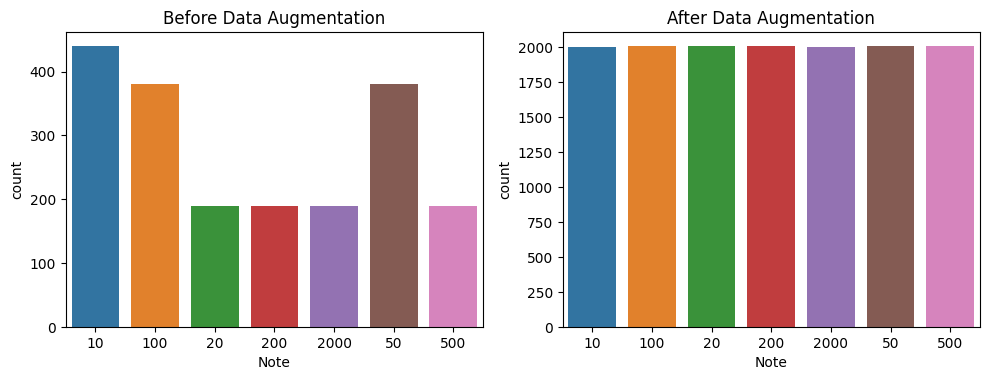

In [54]:
plt.figure(figsize = (10, 7))

plt.subplot(2, 2, 1)
plt.title("Before Data Augmentation")
sns.countplot(x = y_before)
plt.xticks(ticks = list(label_map.keys()), labels = list(map(int, class_names)))
plt.xlabel("Note")

plt.subplot(2, 2, 2)
plt.title("After Data Augmentation")
sns.countplot(x = y)
plt.xticks(ticks = list(label_map.keys()), labels = list(map(int, class_names)))
plt.xlabel("Note")

plt.tight_layout()
plt.show()

### Data Preparation

In [55]:
# Splitting the data into training, testing and validation sets ( based on Stratified Random Sampling )

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15, 
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.2, 
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(9544, 128, 128, 1) (2387, 128, 128, 1) (2106, 128, 128, 1)
Total instances: 14037
Train instances: 9544           
Validation instances: 2387
Test instances: 2106


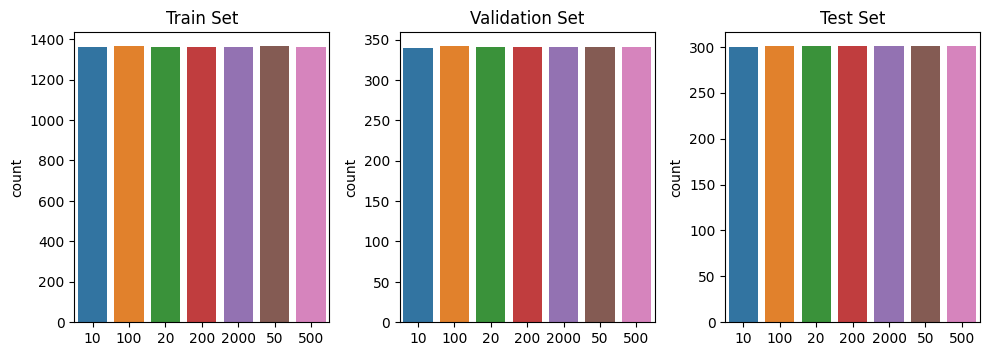

In [56]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.xticks(ticks = list(label_map.keys()), labels = list(map(int, class_names)))
    plt.tight_layout()
plt.show()

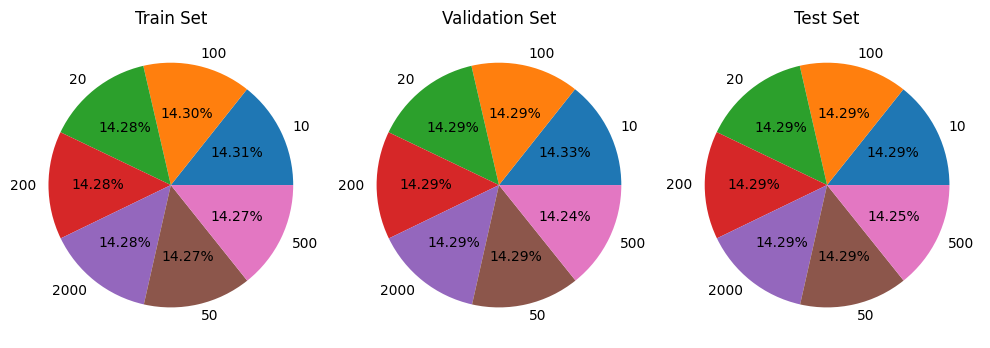

In [57]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_map.values())
    plt.tight_layout()
plt.show()

### Model Building and Training

#### CNN

In [58]:
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(units = 200, activation = "relu"),
tf.keras.layers.Dense(units = 100, activation = "relu"),
tf.keras.layers.Dense(units = 50, activation = "relu"),
tf.keras.layers.Dense(units = 7, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])
#cb1 = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history = model.fit(x = X_train, y = y_train, epochs = 50, validation_data = (X_val, y_val))
# Evaluating the model on train set
train_loss_cnn, train_acc_cnn = model.evaluate(X_train, y_train)
# Evaluating the model on test set
test_loss_cnn, test_acc_cnn = model.evaluate(X_test, y_test)

Epoch 1/50
299/299 [==============================] - 11s 27ms/step - loss: 1.9466 - accuracy: 0.1412 - val_loss: 1.9469 - val_accuracy: 0.1429
Epoch 2/50
299/299 [==============================] - 7s 24ms/step - loss: 1.9463 - accuracy: 0.1401 - val_loss: 1.9467 - val_accuracy: 0.1429
Epoch 3/50
299/299 [==============================] - 7s 24ms/step - loss: 1.9462 - accuracy: 0.1375 - val_loss: 1.9460 - val_accuracy: 0.1420
Epoch 4/50
299/299 [==============================] - 7s 24ms/step - loss: 1.9463 - accuracy: 0.1451 - val_loss: 1.9461 - val_accuracy: 0.1445
Epoch 5/50
299/299 [==============================] - 7s 24ms/step - loss: 1.9464 - accuracy: 0.1336 - val_loss: 1.9459 - val_accuracy: 0.1429
Epoch 6/50
299/299 [==============================] - 7s 24ms/step - loss: 1.9461 - accuracy: 0.1398 - val_loss: 1.9459 - val_accuracy: 0.1429
Epoch 7/50
299/299 [==============================] - 7s 24ms/step - loss: 1.9461 - accuracy: 0.1372 - val_loss: 1.9459 - val_accuracy: 0.144

#### ResNet - 18

In [17]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense

def residual_block(x, filters, kernel_size = 3, strides = 1):
    shortcut = x
    x = Conv2D(filters, kernel_size = kernel_size, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size = kernel_size, padding = 'same')(x)
    x = BatchNormalization()(x)
    if strides > 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size = 1, strides = strides, padding = 'same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x
def build_resnet(input_shape, num_classes):
    input_tensor = Input(shape = input_shape)
    x = Conv2D(64, kernel_size = 7, strides = 2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = residual_block(x, filters = 64)
    x = residual_block(x, filters = 64)
    x = residual_block(x, filters = 128, strides = 2)
    x = residual_block(x, filters = 128)
    x = residual_block(x, filters = 256, strides = 2)
    x = residual_block(x, filters = 256)
    x = residual_block(x, filters = 512, strides = 2)
    x = residual_block(x, filters = 512)
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor, name='resnet')
    return model
input_shape = (128, 128, 1) 
num_classes = 7  
model = build_resnet(input_shape, num_classes)
model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])
cb1 = tf.keras.callbacks.EarlyStopping(patience = 12, restore_best_weights = True)
history = model.fit(x = X_train, y = y_train, epochs = 45, callbacks = [cb1], validation_data = (X_val, y_val))

# Evaluating the model on train set

train_loss, train_acc = model.evaluate(X_train, y_train)

# Evaluating the model on test set

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/45
299/299 [==============================] - 38s 68ms/step - loss: 1.9261 - accuracy: 0.2366 - val_loss: 1.9908 - val_accuracy: 0.1571
Epoch 2/45
299/299 [==============================] - 18s 62ms/step - loss: 1.6951 - accuracy: 0.3127 - val_loss: 25.9190 - val_accuracy: 0.1433
Epoch 3/45
299/299 [==============================] - 19s 62ms/step - loss: 1.5954 - accuracy: 0.3617 - val_loss: 26.7218 - val_accuracy: 0.1575
Epoch 4/45
299/299 [==============================] - 19s 62ms/step - loss: 1.4207 - accuracy: 0.4316 - val_loss: 2.7136 - val_accuracy: 0.2015
Epoch 5/45
299/299 [==============================] - 19s 62ms/step - loss: 1.2814 - accuracy: 0.4856 - val_loss: 6.5278 - val_accuracy: 0.1889
Epoch 6/45
299/299 [==============================] - 19s 62ms/step - loss: 1.1366 - accuracy: 0.5490 - val_loss: 3.6784 - val_accuracy: 0.2187
Epoch 7/45
299/299 [==============================] - 19s 62ms/step - loss: 0.9784 - accuracy: 0.6224 - val_loss: 4.5710 - val_accurac

#### VGGNet ( VGG16 )

In [ ]:
#### from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# def vgg_block(x, num_filters, num_conv):
#     for _ in range(num_conv):
#         x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2))(x)
#     return x

# def build_vgg_custom(input_shape, num_classes):
#     input_tensor = Input(shape=input_shape)

#     x = vgg_block(input_tensor, 32, 2)
#     x = vgg_block(x, 64, 2)
#     x = vgg_block(x, 128, 3)
#     x = vgg_block(x, 256, 3)
#     x = vgg_block(x, 256, 3)

#     x = Flatten()(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dense(512, activation='relu')(x)
#     output_tensor = Dense(num_classes, activation='softmax')(x)

#     model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor, name='vgg_custom')

#     return model

# input_shape = (128, 128, 1)  
# num_classes = 7 

# model = build_vgg16(input_shape, num_classes)

# model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

# cb1 = tf.keras.callbacks.EarlyStopping(patience = 7, restore_best_weights = True)

# history = model.fit(x = X_train, y = y_train, epochs = 100, callbacks = [cb1], validation_data = (X_val, y_val))

# # Evaluating the model on train set

# train_loss, train_acc = model.evaluate(X_train, y_train)

# # Evaluating the model on test set

# test_loss, test_acc = model.evaluate(X_test, y_test)

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 126, 126, 200)     2000      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 42, 42, 200)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 40, 40, 200)       360200    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 200)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 11, 11, 100)       180100    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 100)        

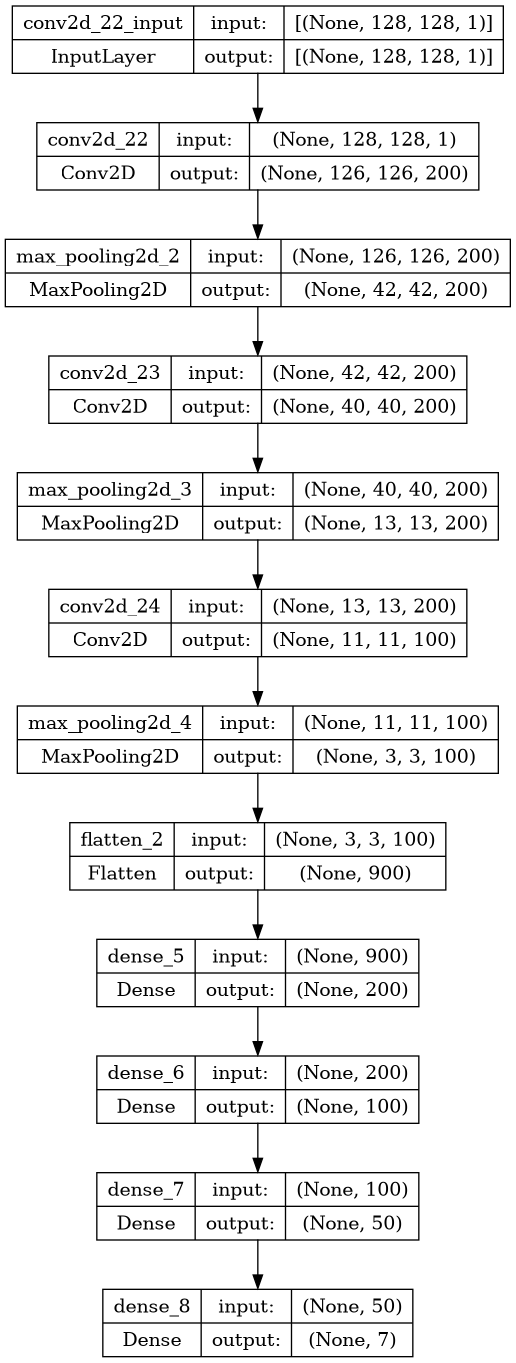

In [60]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [61]:
result_df = pd.DataFrame(history.history)
result_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.946620,0.141241,1.946870,0.142857
1,1.946257,0.140088,1.946670,0.142857
2,1.946243,0.137469,1.946050,0.142019
3,1.946311,0.145117,1.946101,0.144533
4,1.946450,0.133592,1.945904,0.142857


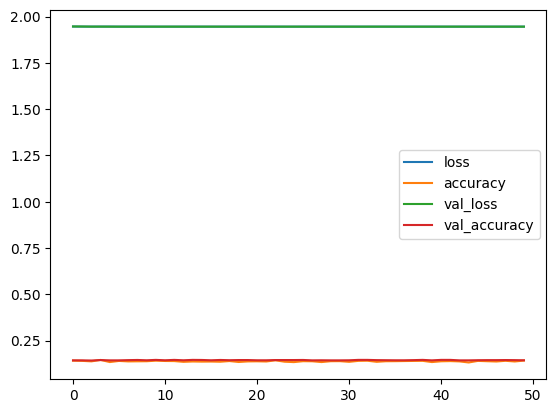

In [62]:
# Plotting learning curves

result_df.plot()
plt.show()

In [23]:
# Classification Report

clf_report = metrics.classification_report(y_train, y_train_pred_labels)
print(clf_report)

NameError: name 'y_train_pred_labels' is not defined

### Model Validation

In [63]:
# Evaluating the model on test set

test_loss, test_acc = model.evaluate(X_test, y_test)

66/66 [==============================] - 1s 8ms/step - loss: 1.9459 - accuracy: 0.1429


66/66 [==============================] - 0s 6ms/step


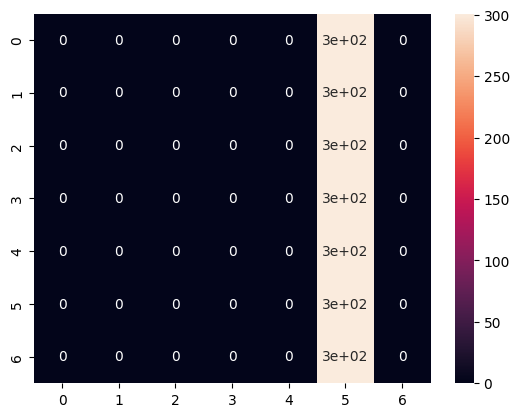

In [64]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [65]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.00      0.00      0.00       301
           2       0.00      0.00      0.00       301
           3       0.00      0.00      0.00       301
           4       0.00      0.00      0.00       301
           5       0.14      1.00      0.25       301
           6       0.00      0.00      0.00       301

    accuracy                           0.14      2106
   macro avg       0.02      0.14      0.04      2106
weighted avg       0.02      0.14      0.04      2106



1/1 [==============================] - 0s 90ms/step


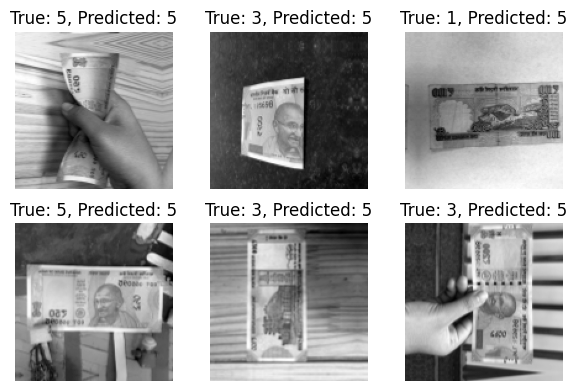

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def show_predictions(model, images, true_labels, figsize=(12, 8), num_rows=2, num_cols=3):
    # Make predictions on the input images
    predictions = model.predict(images)

    # If true_labels are one-hot encoded, convert them to class indices
    if true_labels.ndim > 1:
        true_labels = np.argmax(true_labels, axis=-1)

    # Convert predicted labels to class indices
    predicted_labels = np.argmax(predictions, axis=-1)

    # Plot the images along with true and predicted labels
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for displaying grayscale images
        
        # Handle scalar and array values for true_labels and predicted_labels
        true_label_i = true_labels[i] if true_labels.ndim == 1 else true_labels[i][0]
        predicted_label_i = predicted_labels[i] if predicted_labels.ndim == 1 else predicted_labels[i][0]
        
        plt.title(f'True: {true_label_i}, Predicted: {predicted_label_i}')
        plt.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

# Assuming X_test contains your six test grayscale images and y_test contains their corresponding labels
show_predictions(model, X_test[:6], y_test[:6], figsize=(6, 4), num_rows=2, num_cols=3)


### Saving the Model

In [40]:
model.save("clf_model.h5")